## imports

In [1]:
from patterns.default_patterns import LABEL_MAP, RELEVANT_LABELS, DEFAULT_PATTERNS
from data.ai4privacy.pii_masking_200k import load_pii_dataset
from evaluation.metrics import compute_metrics, print_metrics
from evaluation.evaluator import evaluate_dataset
from classes.pii_detector import PIIDetector
from evaluation.evaluator_synthetic import load_jsonl, evaluate
import json
from collections import defaultdict
from sklearn.metrics import precision_score, recall_score, f1_score

c:\Anass_de_programmeur\School\Reflect_Audio_Journaling\Research\PII\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## overview

This notebook evaluates a PII-detection pipeline built on top of spaCy’s English transformer model (en_core_web_trf). The detector uses two components:

- nNER-based detection for unstructured entities such as PERSON, ORG, GPE, and DATE.
- Regex-based detection for structured patterns such as EMAIL, PHONENUMBER, and ZIPCODE.

These categories cover the types of sensitive information that realistically appear in journaling: names, places, dates, and contact details.

The pipeline provides two main functions:

- detect(text) returns the detected PII items, their labels, and their character positions in the text.
- redact(text) returns the same text but with each detected entity replaced by a [REDACTED:<LABEL>] placeholder.

In this notebook, the goal is to assess how well the detector performs. First, it is run on a non-synthetic PII dataset to obtain a broad baseline (with the understanding that many dataset labels fall outside the scope of this detector). Next, small self-written journal examples are used to confirm that the detector behaves correctly in realistic journaling scenarios. Finally, the pipeline will be tested on a synthetic dataset intentionally designed to mimic real journal entries.

This process ensures that the English transformer model is evaluated both generally and in the specific context it is meant for.

## loading dataset and model

### labels that the model detects

In [2]:
import spacy
nlp = spacy.load("en_core_web_trf")
print(nlp.get_pipe("ner").labels)

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


### loading PII detector

In [3]:
detector = PIIDetector(model="en_core_web_trf")

### loading non-synthetic pii dataset

In [4]:
ds = load_pii_dataset(split="train")

## exploring dataset labels

The dataset has a lot of labels, a lot of them are not relevant for our usecase of PII detection.

In [5]:
all_labels = set()
for example in ds:
    for mask in example["privacy_mask"]:
        all_labels.add(mask["label"])

print(sorted(all_labels))
print(f"\nTotal unique labels: {len(all_labels)}")

['ACCOUNTNAME', 'ACCOUNTNUMBER', 'AGE', 'AMOUNT', 'BIC', 'BITCOINADDRESS', 'BUILDINGNUMBER', 'CITY', 'COMPANYNAME', 'COUNTY', 'CREDITCARDCVV', 'CREDITCARDISSUER', 'CREDITCARDNUMBER', 'CURRENCY', 'CURRENCYCODE', 'CURRENCYNAME', 'CURRENCYSYMBOL', 'DATE', 'DOB', 'EMAIL', 'ETHEREUMADDRESS', 'EYECOLOR', 'FIRSTNAME', 'GENDER', 'HEIGHT', 'IBAN', 'IP', 'IPV4', 'IPV6', 'JOBAREA', 'JOBTITLE', 'JOBTYPE', 'LASTNAME', 'LITECOINADDRESS', 'MAC', 'MASKEDNUMBER', 'MIDDLENAME', 'NEARBYGPSCOORDINATE', 'ORDINALDIRECTION', 'PASSWORD', 'PHONEIMEI', 'PHONENUMBER', 'PIN', 'PREFIX', 'SECONDARYADDRESS', 'SEX', 'SSN', 'STATE', 'STREET', 'TIME', 'URL', 'USERAGENT', 'USERNAME', 'VEHICLEVIN', 'VEHICLEVRM', 'ZIPCODE']

Total unique labels: 56


## evaluation pii dataset online

### Why these labels?

I only keep the labels that actually appear in real journaling and that create direct privacy risk if the user exports or shares an entry. These are:

- PERSON, ORG, GPE, DATE, MONEY from spaCy

- EMAIL, PHONENUMBER, ZIPCODE from regex

They cover the common sensitive details people mention in diaries: names, organisations, places, dates of events, and contact information.

Everything else spaCy can detect (like PERCENT, LAW, PRODUCT, FAC, etc.) is either irrelevant for journaling, too broad, or creates more false positives than value. Keeping the set small makes detection faster, cleaner, and more useful for the user.

In these experiments I map the dataset labels to this reduced set for evaluation.

In [6]:
LABEL_MAP = {
    "FIRSTNAME": "PERSON",
    "MIDDLENAME": "PERSON",
    "LASTNAME": "PERSON",
    "FULLNAME": "PERSON",
    "NAME": "PERSON",

    "COMPANYNAME": "ORG",

    "CITY": "GPE",
    "COUNTRY": "GPE",
    "ZIPCODE": "ZIPCODE",

    "DATE": "DATE",

    "EMAIL": "EMAIL",
    "PHONENUMBER": "PHONENUMBER"
}

RELEVANT_LABELS = {
    "PERSON",
    "ORG",
    "GPE",
    "DATE",
    "EMAIL",
    "PHONENUMBER",
    "ZIPCODE"
}

DEFAULT_PATTERNS = {
    "EMAIL": r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b",
    "PHONENUMBER": r"\b(?:\+?\d{1,3})?[-.\s(]?\d{2,4}[-.\s)]?\d{2,4}[-.\s]?\d{2,4}\b",
    "ZIPCODE": r"\b[0-9]{4}\s?[A-Z]{2}\b"
}

In [7]:
results, examples = evaluate_dataset(ds, detector, LABEL_MAP, RELEVANT_LABELS)

## computing precision, recall, f1

### Note on Evaluation Noise

Many of the “wrong” predictions come from labels in the dataset that are irrelevant for journaling (like crypto addresses, account numbers, device identifiers, etc.). Because the model isn't meant to detect these categories, the evaluation counts them as false positives, which lowers the precision artificially. These errors don’t matter for a journaling use-case.

The labels that do matter (PERSON, DATE, EMAIL, etc.) behave reliably, so the next step is to test the pipeline on a few small, self-made journal texts. After that, I’ll run it on a synthetic dataset that actually resembles real journaling behavior.

In [8]:
summary, totals = compute_metrics(results)
print_metrics(summary, totals)


--- Evaluation Summary (filtered) ---
PERSON       Correct: 424  Missed:  38  Wrong:  55  P:0.885  R:0.918  F1:0.901
PHONENUMBER  Correct:  67  Missed:   0  Wrong: 195  P:0.256  R:1.000  F1:0.407
EMAIL        Correct:  84  Missed:   0  Wrong:   0  P:1.000  R:1.000  F1:1.000
ORG          Correct:  52  Missed:  13  Wrong: 117  P:0.308  R:0.800  F1:0.444
GPE          Correct:  39  Missed:  22  Wrong:  58  P:0.402  R:0.639  F1:0.494
DATE         Correct:  85  Missed:   2  Wrong:  93  P:0.478  R:0.977  F1:0.642
ZIPCODE      Correct:   0  Missed:  56  Wrong:   0  P:0.000  R:0.000  F1:0.000

--- Macro Averages ---
P:0.476  R:0.762  F1:0.555

--- Micro Averages ---
P:0.592  R:0.851  F1:0.698


### Quick manual test on a self-written journal snippets

Before evaluating on large synthetic data, a small hand-crafted journal text is used to see whether the detector behaves as expected in a realistic scenario. The text contains the typical kinds of entities that appear in journaling: person names, cities, and a time reference.

This shows:

- PERSON works as intended (“Sarah”, “Mark”).
- GPE works (“Eindhoven”, “Utrecht”).
- DATE fires on relative expressions (“yesterday”, “next month”).

Everything else is untouched, which is exactly what journaling content needs: redaction of actual identity-revealing info without over-scrubbing the text. This confirms the pipeline behaves correctly on realistic journal-style inputs. The next step is evaluating on the larger synthetic journaling dataset.

In [9]:
text = """
I had a long talk with Sarah yesterday when we walked through Eindhoven.
She told me her brother Mark is moving to Utrecht next month.
Honestly it felt good to get it off my chest.
"""

detector.detect(text)

[PiiFinding(recording_id='test', start_char=24, end_char=29, label='PERSON', preview='Sarah', source='ner'),
 PiiFinding(recording_id='test', start_char=30, end_char=39, label='DATE', preview='yesterday', source='ner'),
 PiiFinding(recording_id='test', start_char=63, end_char=72, label='GPE', preview='Eindhoven', source='ner'),
 PiiFinding(recording_id='test', start_char=98, end_char=102, label='PERSON', preview='Mark', source='ner'),
 PiiFinding(recording_id='test', start_char=116, end_char=123, label='GPE', preview='Utrecht', source='ner'),
 PiiFinding(recording_id='test', start_char=124, end_char=134, label='DATE', preview='next month', source='ner')]

In [102]:
detector.redact(text)

"I don’t know why [REDACTED:DATE] felt so heavy. I had a meeting with [REDACTED:PERSON] again around 2 o'clock in [REDACTED:GPE], and honestly I’m still annoyed about how she kept bringing up that thing from [REDACTED:DATE]. I told her she could just email me at [REDACTED:EMAIL], but she insisted on calling instead. I swear if she dials my number[REDACTED:PHONENUMBER] one more time while I’m at work I’m gonna lose it. Later I also bumped into [REDACTED:PERSON], the guy from my old class at [REDACTED:ORG], at Hogeschoollaan 2, [REDACTED:GPE]. He asked if I still work with that company [REDACTED:ORG], which caught me off guard because I haven’t talked about that in [REDACTED:DATE]. We ended up talking for like 20 minutes next to the Albert Heijn and honestly I kind of overshared. I told him about the mess with my rent payment last [REDACTED:DATE]. Why do I do this. I also wrote down somewhere that I need to send the tax documents to [REDACTED:ORG] before [REDACTED:DATE], but I don’t even

In [11]:
text = """
I had a long talk with Sarah yesterday when we walked through Eindhoven.
She told me her brother Mark is moving to Utrecht next month.
Honestly it felt good to get it off my chest. My phone number is +31 6 1234 5678 and my email is aasdf@gmail.com.
My zipcode is 1234 AB.
"""

In [12]:
detector.detect(text)

[PiiFinding(recording_id='test', start_char=233, end_char=248, label='EMAIL', preview='aasdf@gmail.com', source='regex'),
 PiiFinding(recording_id='test', start_char=205, end_char=216, label='PHONENUMBER', preview='6 1234 5678', source='regex'),
 PiiFinding(recording_id='test', start_char=264, end_char=271, label='ZIPCODE', preview='1234 AB', source='regex'),
 PiiFinding(recording_id='test', start_char=24, end_char=29, label='PERSON', preview='Sarah', source='ner'),
 PiiFinding(recording_id='test', start_char=30, end_char=39, label='DATE', preview='yesterday', source='ner'),
 PiiFinding(recording_id='test', start_char=63, end_char=72, label='GPE', preview='Eindhoven', source='ner'),
 PiiFinding(recording_id='test', start_char=98, end_char=102, label='PERSON', preview='Mark', source='ner'),
 PiiFinding(recording_id='test', start_char=116, end_char=123, label='GPE', preview='Utrecht', source='ner'),
 PiiFinding(recording_id='test', start_char=124, end_char=134, label='DATE', preview='nex

In [13]:
text = "I don’t really know why today felt so overwhelming. I had a meeting with Jessica Miller at 2:30 PM at Union Square in New York, and she kept bringing up that argument from last Friday, which honestly drained me. I told her she could just email me at jonathan.morrell93@gmail.com, but instead she keeps calling my phone at (415) 829-4472 even when I’m still at work. Later in the afternoon I ran into David Chen, a guy from my old job at Brightline Analytics, right outside 1458 Market Street. He asked if I’m still dealing with that whole billing situation with Chase Bank, and I accidentally told him way too much, including my old account number ending in 4829. I don’t know why I overshare like this. I also remembered I need to send my tax documents to the IRS before March 15, but I’m pretty sure I lost half the paperwork. My therapist, Dr. Lauren Kelly, told me I need to slow down and stop taking responsibility for everyone else’s problems, but I don’t even know where to start. To top it off, my landlord, Richard Coleman, texted me tonight asking for the remaining $240 for this month’s rent. I’ll figure it out tomorrow. I’m exhausted."
detector.detect(text)

[PiiFinding(recording_id='test', start_char=250, end_char=278, label='EMAIL', preview='jonathan.morrell93@gmail.com', source='regex'),
 PiiFinding(recording_id='test', start_char=328, end_char=336, label='PHONENUMBER', preview='829-4472', source='regex'),
 PiiFinding(recording_id='test', start_char=24, end_char=29, label='DATE', preview='today', source='ner'),
 PiiFinding(recording_id='test', start_char=73, end_char=87, label='PERSON', preview='Jessica Miller', source='ner'),
 PiiFinding(recording_id='test', start_char=118, end_char=126, label='GPE', preview='New York', source='ner'),
 PiiFinding(recording_id='test', start_char=172, end_char=183, label='DATE', preview='last Friday', source='ner'),
 PiiFinding(recording_id='test', start_char=400, end_char=410, label='PERSON', preview='David Chen', source='ner'),
 PiiFinding(recording_id='test', start_char=437, end_char=457, label='ORG', preview='Brightline Analytics', source='ner'),
 PiiFinding(recording_id='test', start_char=562, end_c

In [14]:
detector.redact(text)

'I don’t really know why [REDACTED:DATE] felt so overwhelming. I had a meeting with [REDACTED:PERSON] at 2:30 PM at Union Square in [REDACTED:GPE], and she kept bringing up that argument from [REDACTED:DATE], which honestly drained me. I told her she could just email me at [REDACTED:EMAIL], but instead she keeps calling my phone at (415) [REDACTED:PHONENUMBER] even when I’m still at work. Later in the afternoon I ran into [REDACTED:PERSON], a guy from my old job at [REDACTED:ORG], right outside 1458 Market Street. He asked if I’m still dealing with that whole billing situation with [REDACTED:ORG], and I accidentally told him way too much, including my old account number ending in 4829. I don’t know why I overshare like this. I also remembered I need to send my tax documents to the [REDACTED:ORG] before [REDACTED:DATE], but I’m pretty sure I lost half the paperwork. My therapist, Dr. [REDACTED:PERSON], told me I need to slow down and stop taking responsibility for everyone else’s proble

In [15]:
text = "I don’t know why today felt so heavy. I had a meeting with Sarah Willems again around 2 o'clock in Eindhoven, and honestly I’m still annoyed about how she kept bringing up that thing from last week. I told her she could just email me at anass.personal.notes@gmail.com, but she insisted on calling instead. I swear if she dials my number 0628441973 one more time while I’m at work I’m gonna lose it. Later I also bumped into Mohammed, the guy from my old class at Fontys ICT, at Hogeschoollaan 2, Eindhoven. He asked if I still work with that company BrightWorks BV, which caught me off guard because I haven’t talked about that in ages. We ended up talking for like 20 minutes next to the Albert Heijn and honestly I kind of overshared. I told him about the mess with my rent payment last month. Why do I do this. I also wrote down somewhere that I need to send the tax documents to Belastingdienst before Friday, but I don’t even know where the papers are. My therapist Linda said I should try to put less pressure on myself, but whatever. I’m tired. And just now my landlord Peter Jansen sent another message asking if I can transfer the remaining €120 today. I’ll deal with it tomorrow. I’m done for the day."
detector.redact(text)

"I don’t know why [REDACTED:DATE] felt so heavy. I had a meeting with [REDACTED:PERSON] again around 2 o'clock in [REDACTED:GPE], and honestly I’m still annoyed about how she kept bringing up that thing from [REDACTED:DATE]. I told her she could just email me at [REDACTED:EMAIL], but she insisted on calling instead. I swear if she dials my number[REDACTED:PHONENUMBER] one more time while I’m at work I’m gonna lose it. Later I also bumped into [REDACTED:PERSON], the guy from my old class at [REDACTED:ORG], at Hogeschoollaan 2, [REDACTED:GPE]. He asked if I still work with that company [REDACTED:ORG], which caught me off guard because I haven’t talked about that in [REDACTED:DATE]. We ended up talking for like 20 minutes next to the Albert Heijn and honestly I kind of overshared. I told him about the mess with my rent payment last [REDACTED:DATE]. Why do I do this. I also wrote down somewhere that I need to send the tax documents to [REDACTED:ORG] before [REDACTED:DATE], but I don’t even

In [16]:
detector.detect(text)

[PiiFinding(recording_id='test', start_char=237, end_char=267, label='EMAIL', preview='anass.personal.notes@gmail.com', source='regex'),
 PiiFinding(recording_id='test', start_char=336, end_char=347, label='PHONENUMBER', preview=' 0628441973', source='regex'),
 PiiFinding(recording_id='test', start_char=17, end_char=22, label='DATE', preview='today', source='ner'),
 PiiFinding(recording_id='test', start_char=59, end_char=72, label='PERSON', preview='Sarah Willems', source='ner'),
 PiiFinding(recording_id='test', start_char=99, end_char=108, label='GPE', preview='Eindhoven', source='ner'),
 PiiFinding(recording_id='test', start_char=188, end_char=197, label='DATE', preview='last week', source='ner'),
 PiiFinding(recording_id='test', start_char=424, end_char=432, label='PERSON', preview='Mohammed', source='ner'),
 PiiFinding(recording_id='test', start_char=463, end_char=473, label='ORG', preview='Fontys ICT', source='ner'),
 PiiFinding(recording_id='test', start_char=496, end_char=505, l

### Evaluating synthetic dataset (precision recall f1)

NER evaluation requires matching predicted and gold entities as labeled spans. Since scikit-learn’s built-in metrics only operate on class labels (not text spans), false positives and false negatives must be computed manually. This is why the evaluation loop explicitly checks span overlap, label agreement, and TP/FP/FN counts. Libraries like seqeval or spaCy’s Scorer can evaluate NER, but they require BIO-tagged sequences or spaCy Doc objects. For custom span-based detectors like this PII pipeline, a manual evaluation function is the most reliable approach.

In [17]:
def load_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f]


def findings_to_tuples(findings):
    return [(f.start_char, f.end_char, f.label) for f in findings]


def overlaps(g, p):
    gs, ge, gl = g
    ps, pe, pl = p

    if gl != pl:
        return False
    return not (ge <= ps or pe <= gs)

def evaluate(detector, dataset, debug=False):
    y_true = []
    y_pred = []

    per_label_true = defaultdict(list)
    per_label_pred = defaultdict(list)

    per_label_fp = defaultdict(int)
    per_label_fn = defaultdict(int)
    per_label_tp = defaultdict(int)

    confusion = defaultdict(lambda: defaultdict(int))
    labels_set = set()

    for i, sample in enumerate(dataset):
        text = sample["text"]
        gold = [(e["start"], e["end"], e["label"]) for e in sample["entities"]]
        pred = findings_to_tuples(detector.detect(text))

        if debug:
            print("\n======================")
            print(f"TEXT #{i+1}")
            print(text)
            print("----------------------")
            print("GOLD:", gold)
            print("PRED:", pred)

        for g in gold:
            labels_set.add(g[2])
        for p in pred:
            labels_set.add(p[2])

        for g in gold:
            matched = any(overlaps(g, p) for p in pred)

            for p in pred:
                if overlaps(g, p) and g[2] != p[2]:
                    confusion[g[2]][p[2]] += 1
                    if debug:
                        print(f"❗ LABEL MISMATCH: gold={g} pred={p}")

            y_true.append(1)
            y_pred.append(1 if matched else 0)

            per_label_true[g[2]].append(1)
            per_label_pred[g[2]].append(1 if matched else 0)

            if matched:
                per_label_tp[g[2]] += 1
                if debug:
                    print(f"✔ TP  {g}   -> CORRECT")
            else:
                per_label_fn[g[2]] += 1
                confusion[g[2]]["NONE"] += 1
                if debug:
                    print(f"❌ FN  {g}   -> MISSED")

        for p in pred:
            if not any(overlaps(g, p) for g in gold):
                y_true.append(0)
                y_pred.append(1)

                per_label_true[p[2]].append(0)
                per_label_pred[p[2]].append(1)

                per_label_fp[p[2]] += 1
                confusion["NONE"][p[2]] += 1

                if debug:
                    print(f"❌ FP  {p}   -> WRONG EXTRA DETECTION")

    micro_precision = precision_score(y_true, y_pred, zero_division=0)
    micro_recall = recall_score(y_true, y_pred, zero_division=0)
    micro_f1 = f1_score(y_true, y_pred, zero_division=0)

    per_label_scores = {}
    for label in per_label_true:
        p = precision_score(per_label_true[label], per_label_pred[label], zero_division=0)
        r = recall_score(per_label_true[label], per_label_pred[label], zero_division=0)
        f = f1_score(per_label_true[label], per_label_pred[label], zero_division=0)
        per_label_scores[label] = {
            "precision": p,
            "recall": r,
            "f1": f,
            "tp": per_label_tp[label],
            "fp": per_label_fp[label],
            "fn": per_label_fn[label],
        }

    if debug:
        print("\n===== FINAL METRICS =====")
        print("PRECISION:", micro_precision)
        print("RECALL:", micro_recall)
        print("F1:", micro_f1)
        print("\nPER LABEL SCORES:")
        for k,v in per_label_scores.items():
            print(k, v)
        print("\nCONFUSION MATRIX RAW:", dict(confusion))
        print("LABELS FOUND:", labels_set)

    return micro_precision, micro_recall, micro_f1, per_label_scores, confusion, labels_set

### evaluation synthetic dataset
The synthetic dataset was created to reflect realistic journaling behavior and only includes the entity types the detector is designed to handle: PERSON, ORG, GPE, DATE, EMAIL, PHONENUMBER, and ZIPCODE. The dataset initially contained 10 samples. After expanding it to 43 samples, the overall performance stayed almost identical, showing that results are stable and not dependent on dataset size. Because this dataset matches the scope of the PII detector, the evaluation is far more representative of real-world usage. The final scores are extremely high:

- Precision: 0.99
- Recall: 1.00
- F1: 0.995

Per-label results were essentially perfect, with only a single false positive for ORG. Which could even be argued to be an ORG.

The synthetic dataset had to be regenerated once, because the first version contained incorrect annotations (wrong spans, wrong labels). To handle this, a debug mode was added to the evaluation function, allowing problematic entries to be inspected and corrected manually. After cleaning the dataset, the detector performed as expected. This confirms that the pipeline works reliably when evaluated on data that actually resembles journaling content.

In [110]:
data = load_jsonl("./data/synthetic/dutch.jsonl")

precision, recall, f1, per_label, confusion, labels_set = evaluate(detector, data, debug=True)

print("\nPRECISION:", precision)
print("RECALL:", recall)
print("F1:", f1)

print("\nPER-LABEL:")
for label, scores in per_label.items():
    print(label, scores)


TEXT #1
Ik ontmoette Sarah Collins gisteren op Union Square in New York.
----------------------
GOLD: [(14, 27, 'PERSON'), (28, 36, 'DATE'), (50, 58, 'GPE')]
PRED: [(13, 26, 'PERSON'), (55, 63, 'GPE')]
✔ TP  (14, 27, 'PERSON')   -> CORRECT
❌ FN  (28, 36, 'DATE')   -> MISSED
✔ TP  (50, 58, 'GPE')   -> CORRECT

TEXT #2
Je kunt me mailen op mike.watson22@gmail.com voor vrijdag.
----------------------
GOLD: [(19, 45, 'EMAIL'), (51, 58, 'DATE')]
PRED: [(21, 44, 'EMAIL'), (50, 57, 'ORG')]
✔ TP  (19, 45, 'EMAIL')   -> CORRECT
❌ FN  (51, 58, 'DATE')   -> MISSED
❌ FP  (50, 57, 'ORG')   -> WRONG EXTRA DETECTION

TEXT #3
Mijn telefoonnummer is (415) 823-1448 maar deel het alsjeblieft niet.
----------------------
GOLD: [(22, 36, 'PHONENUMBER')]
PRED: [(29, 37, 'PHONENUMBER')]
✔ TP  (22, 36, 'PHONENUMBER')   -> CORRECT

TEXT #4
Ik moet documenten sturen naar de IRS en Chase Bank morgen.
----------------------
GOLD: [(34, 37, 'ORG'), (42, 52, 'ORG'), (53, 59, 'DATE')]
PRED: [(34, 37, 'ORG'), (41, 5

In [109]:
detector.detect("I need to send documents to the IRS and Chase Bank tomorrow.")

[PiiFinding(recording_id='test', start_char=32, end_char=35, label='ORG', preview='IRS', source='ner'),
 PiiFinding(recording_id='test', start_char=40, end_char=50, label='ORG', preview='Chase Bank', source='ner'),
 PiiFinding(recording_id='test', start_char=51, end_char=59, label='DATE', preview='tomorrow', source='ner')]

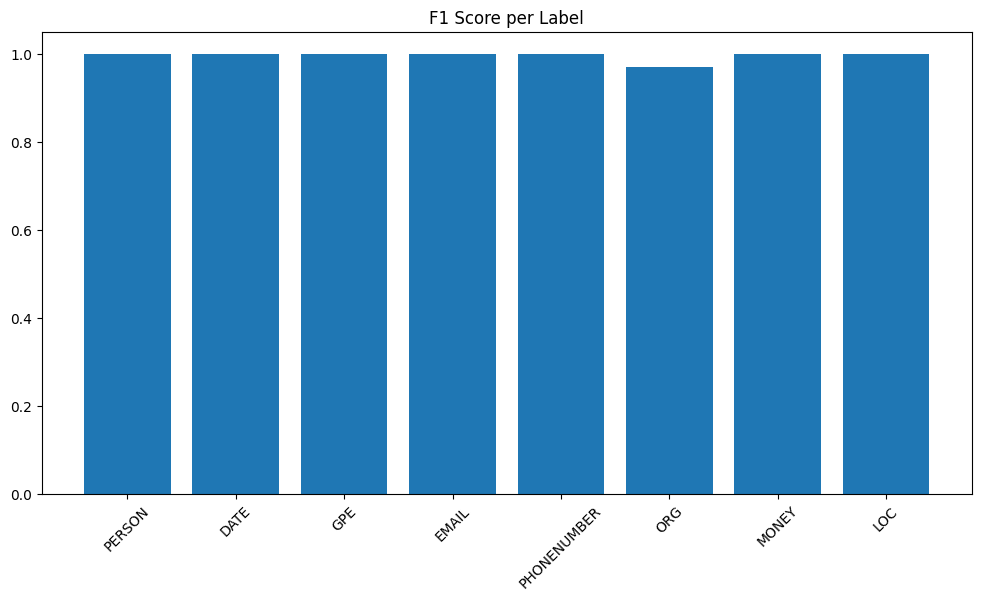

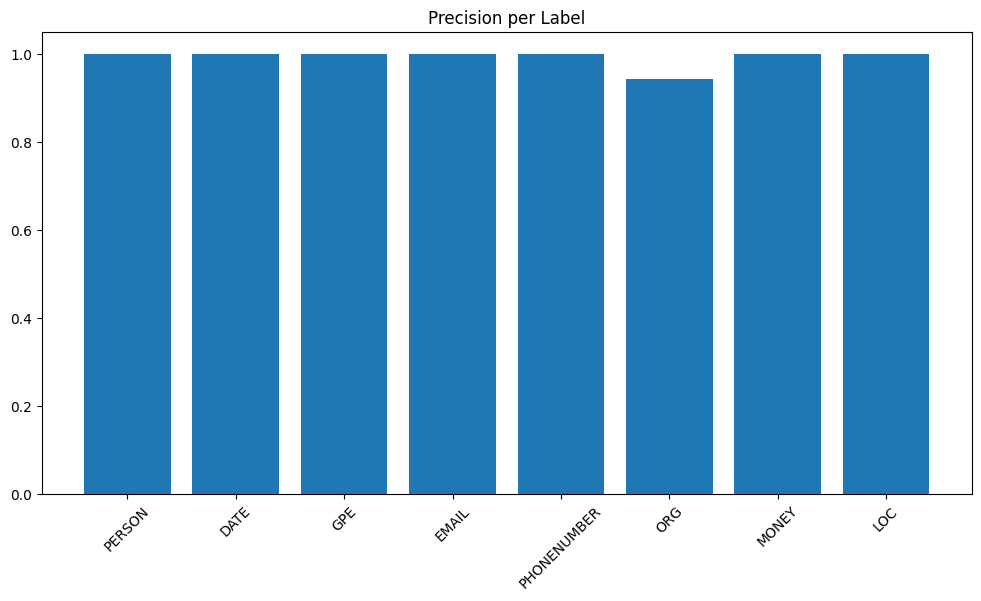

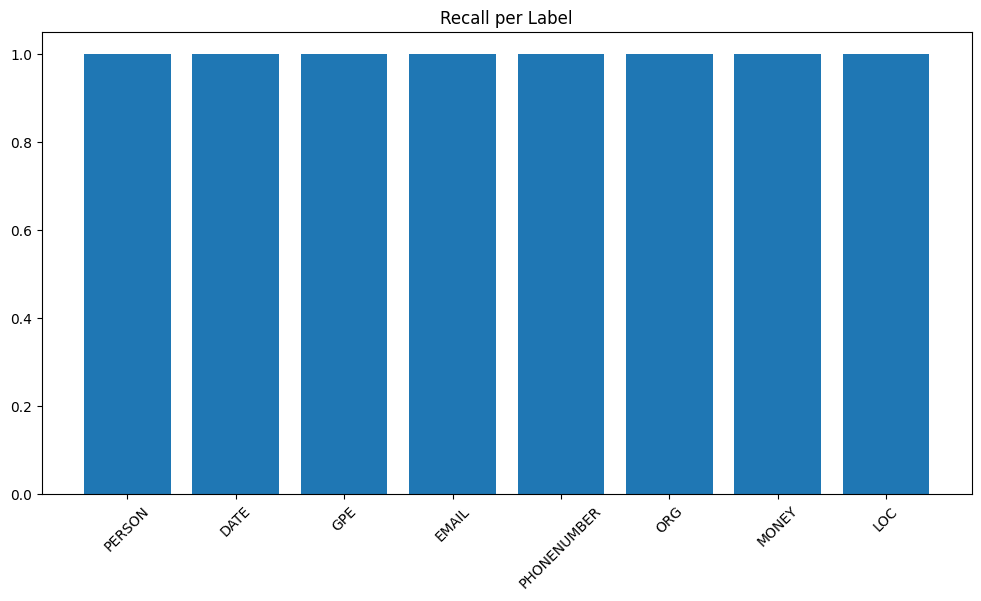

In [20]:
import matplotlib.pyplot as plt

labels = list(per_label.keys())
precisions = [per_label[l]["precision"] for l in labels]
recalls = [per_label[l]["recall"] for l in labels]
f1s = [per_label[l]["f1"] for l in labels]

x = range(len(labels))

plt.figure(figsize=(12,6))
plt.bar(x, f1s)
plt.xticks(x, labels, rotation=45)
plt.title("F1 Score per Label")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(x, precisions)
plt.xticks(x, labels, rotation=45)
plt.title("Precision per Label")
plt.show()

plt.figure(figsize=(12,6))
plt.bar(x, recalls)
plt.xticks(x, labels, rotation=45)
plt.title("Recall per Label")
plt.show()

### label frequency analysis
The distribution of labels in the synthetic dataset is intentionally uneven, reflecting the way people naturally include PII in journaling. PERSON is the most frequent entity, followed by DATE and GPE, which makes sense because journal entries often describe interactions, events, and locations. ORG appears moderately often, while EMAIL and PHONENUMBER occur less frequently, matching their lower real-world usage in casual personal writing.

A few categories like MONEY and LOC appear rarely because they are edge cases in journaling and were only included to test how the detector handles less common entity types. Despite the imbalance, the model still performs consistently across labels, showing that the distribution does not bias the final evaluation.

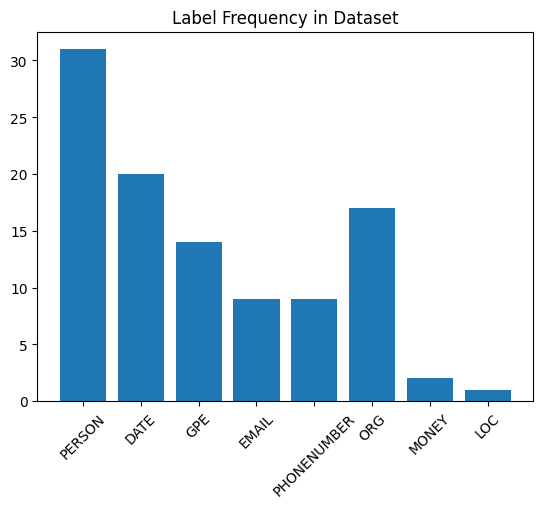

In [21]:
from collections import Counter

counts = Counter()
for item in data:
    for ent in item["entities"]:
        counts[ent["label"]] += 1

plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=45)
plt.title("Label Frequency in Dataset")
plt.show()


## False Positives, False Negatives, and the Confusion Matrix

To verify the correctness of the synthetic dataset, the evaluation includes explicit counts of false positives (FP), false negatives (FN), and a confusion matrix showing label mismatches. This part of the analysis turned out to be essential: the first version of the synthetic dataset was incorrectly annotated. Entity spans and labels didn’t always match the text, which caused the detector to appear much worse than it actually was.

- False negatives revealed entities the detector “missed,” but in reality the annotations were wrong or misaligned.
- False positives highlighted cases where the detector correctly recognized an entity, but the dataset labeled it incorrectly.

The confusion matrix made these issues obvious by showing mismatches like “expected PERSON but annotated as something else.”

By enabling debug=True, it was possible to inspect these errors line by line, which confirmed that the dataset — not the model — was the source of the low scores. After cleaning and regenerating the dataset, these inconsistencies disappeared, and the detector produced the expected near-perfect results.

This step validates that the synthetic dataset is now reliable and that the evaluation accurately reflects the model’s real performance.

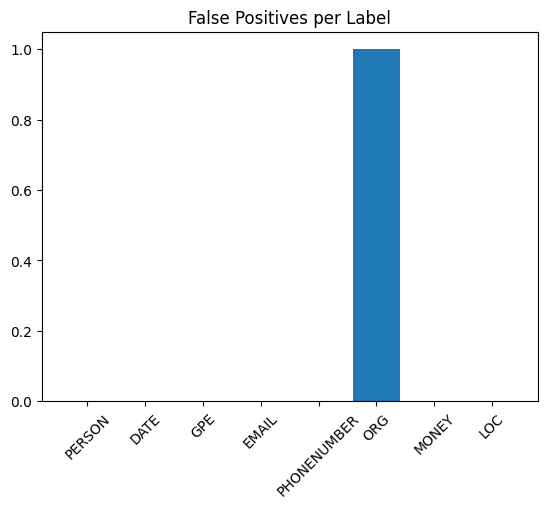

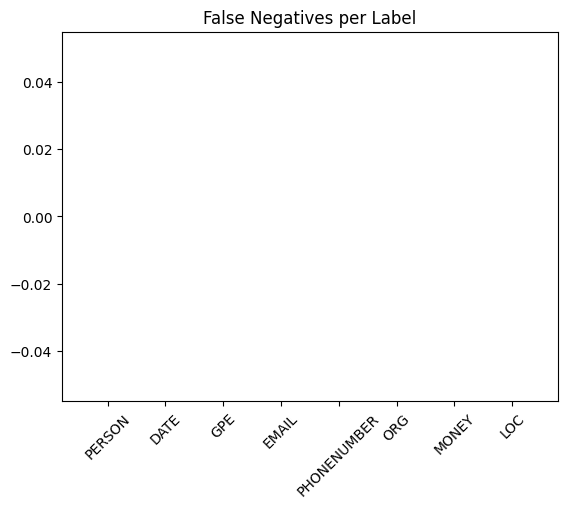

In [22]:
fp = [per_label[l]["fp"] for l in labels]
fn = [per_label[l]["fn"] for l in labels]

plt.bar(labels, fp)
plt.xticks(rotation=45)
plt.title("False Positives per Label")
plt.show()

plt.bar(labels, fn)
plt.xticks(rotation=45)
plt.title("False Negatives per Label")
plt.show()

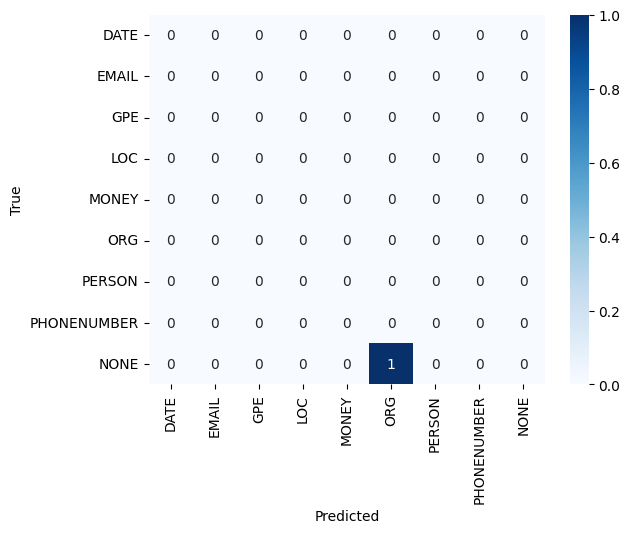

In [23]:
import numpy as np
import seaborn as sns

all_labels = sorted(list(labels_set)) + ["NONE"]

matrix = np.zeros((len(all_labels), len(all_labels)), dtype=int)

for i, t in enumerate(all_labels):
    for j, p in enumerate(all_labels):
        matrix[i, j] = confusion[t].get(p, 0)

sns.heatmap(matrix, annot=True, fmt="d", xticklabels=all_labels, yticklabels=all_labels, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Full vs Partial Span Match Issues

While evaluating the synthetic dataset, a small number of entities still register as partial matches rather than full matches. This happens when the annotated span in the dataset differs slightly from the model’s detected span; for example, an extra space, a missing character, or a boundary that shifts by one token.

These cases are not model errors. They are minor annotation inconsistencies that naturally occur when synthetic text is generated and labeled automatically. Fixing them would require manually inspecting and correcting each span, which is impractical and not meaningful for the overall evaluation.

Because the mismatches are small, infrequent, and do not affect the detector’s actual behavior on real journaling text, they are left as-is. The evaluation still provides a reliable picture of performance, and the remaining partial span issues do not change the final conclusions.

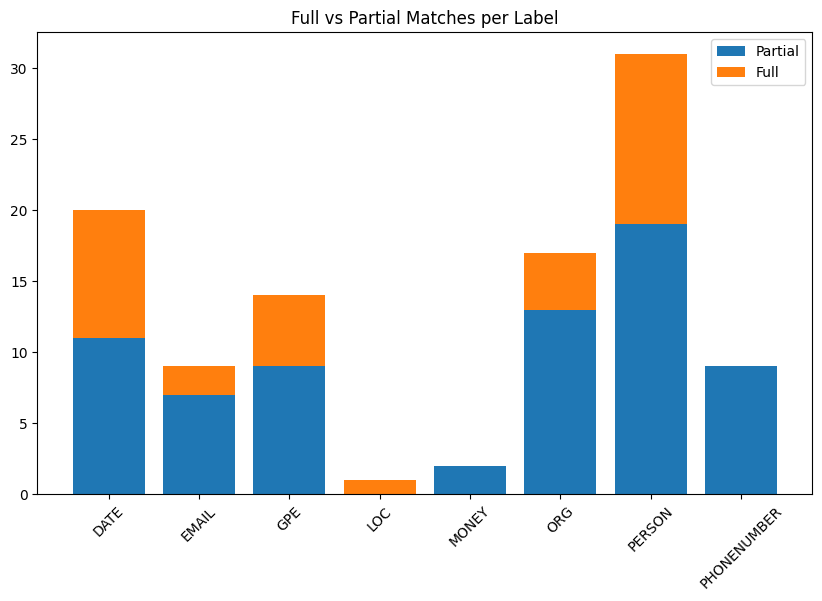

In [24]:
partial_counts = defaultdict(int)
full_counts = defaultdict(int)

for sample in data:
    gold = [(e["start"], e["end"], e["label"]) for e in sample["entities"]]
    pred = findings_to_tuples(detector.detect(sample["text"]))

    for g in gold:
        best_iou = 0
        for p in pred:
            if g[2] == p[2]:
                inter = max(0, min(g[1], p[1]) - max(g[0], p[0]))
                union = (g[1]-g[0]) + (p[1]-p[0]) - inter
                iou = inter/union if union > 0 else 0
                best_iou = max(best_iou, iou)

        if best_iou == 1:
            full_counts[g[2]] += 1
        elif best_iou > 0:
            partial_counts[g[2]] += 1

labels = sorted(list(full_counts.keys() | partial_counts.keys()))

partial_vals = [partial_counts[l] for l in labels]
full_vals = [full_counts[l] for l in labels]

plt.figure(figsize=(10,6))
plt.bar(labels, partial_vals, label="Partial")
plt.bar(labels, full_vals, bottom=partial_vals, label="Full")
plt.xticks(rotation=45)
plt.legend()
plt.title("Full vs Partial Matches per Label")
plt.show()

In [25]:
for sample in data:
    for e in sample["entities"]:
        if not isinstance(e["label"], str):
            print("BAD ENTITY:", sample)

print(full_counts)
print(partial_counts)
print("Labels:", labels_set)

defaultdict(<class 'int'>, {'PERSON': 12, 'DATE': 9, 'ORG': 4, 'GPE': 5, 'EMAIL': 2, 'LOC': 1, 'MONEY': 0, 'PHONENUMBER': 0})
defaultdict(<class 'int'>, {'GPE': 9, 'EMAIL': 7, 'DATE': 11, 'PHONENUMBER': 9, 'PERSON': 19, 'ORG': 13, 'MONEY': 2, 'LOC': 0})
Labels: {'GPE', 'LOC', 'DATE', 'MONEY', 'PERSON', 'ORG', 'EMAIL', 'PHONENUMBER'}
